In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma, gammaincc, gammainc
from scipy.integrate import quad
from scipy.stats import gamma as gamma_pdf

import sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import jax
jax.config.update("jax_enable_x64", True)

from lib.cgamma_biweight import c_gamma_biweight_prob as biweight_gamma
'''
def biweight_gamma(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    gincc_a_m = gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)
    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)
    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)
    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * b**4 * (s**4 - 2*s**2*x**2 + x**4)
                + (g_1pa - gincc_1pa) * b**3 * (4*s**2*x - 4*x**3)
                + (g_2pa - gincc_2pa) * (b**2*(6*x**2 - 2*s**2))
                - g_2pa * (8*b*x + 4*a*b*x)
                + g_4pa - gincc_4pa
                + gincc_3pa * 4*b*x
    )
    
    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * (b**4*s**4 - 2*b**4*s**2*x**2 + b**4*x**4)
                + (gincc_1pa_m - gincc_1pa) * (4*b**3*s**2*x - 4*b**3*x**3)
                + (gincc_2pa- gincc_2pa_m) * (2*b**2*s**2 - 6*b**2*x**2)
                + (gincc_3pa - gincc_3pa_m) * (4*b*x)
                + gincc_4pa_m - gincc_4pa
                
    )

    tsum = np.where(x < s, tsum0, tsum1)
    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum
'''

'\ndef biweight_gamma(x, a, b, s):\n    g_a = gamma(a)\n    g_1pa = gamma(1+a)\n    g_2pa = gamma(2+a)\n    g_4pa = gamma(4+a)\n\n    gincc_a = gammaincc(a, b*(s+x)) * g_a\n    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)\n    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)\n    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)\n    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)\n\n    gincc_a_m = gammaincc(a, b*(x-s)) * g_a\n    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)\n    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)\n    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)\n    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)\n\n    # branch 0 (-s < t < +s)\n    tsum0 = (\n                (g_a - gincc_a) * b**4 * (s**4 - 2*s**2*x**2 + x**4)\n                + (g_1pa - gincc_1pa) * b**3 * (4*s**2*x - 4*x**3)\n                + (g_2pa - gincc_2pa) * (b**2*(6*x**2 - 2*s**2))\n                - g_2pa * (8*b*x + 4*a*b*x)\n                + g_4pa - gincc_4pa\n                + gincc

In [2]:
def biweight(x, u, s):
    y =  15./(16.*s) * (1.0-((x-u)/s)**2)**2
    y = np.where(np.abs(x-u) <= s, y, 0.0)
    return y

def gamma_pdf_fn(x, a, b):
    y = gamma_pdf.pdf(x, a, scale=1/b)
    y = np.where(x <= 0, 0.0, y)
    return y

In [23]:
sigma = 3.0
mu = 0.0
xvals = np.linspace(-3*sigma, 100, 10000)
yvals_norm = norm.pdf(xvals, mu, scale=sigma)
yvals_biweight = biweight(xvals, mu, 3*sigma)
yvals_gamma = gamma_pdf_fn(xvals, 3.75, 0.1)
print(yvals_gamma.shape)
print(yvals_biweight.shape)

(10000,)
(10000,)


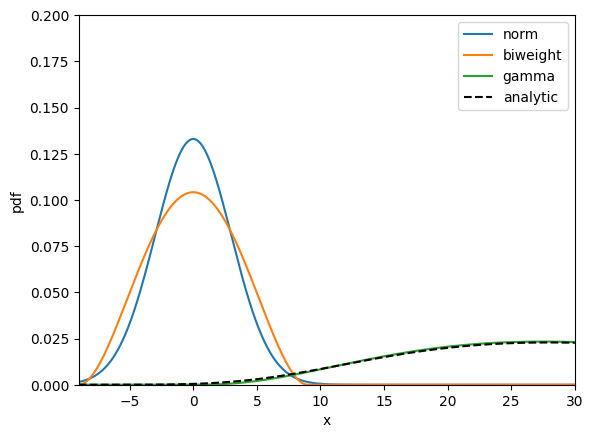

In [24]:
plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_gamma, yvals_biweight, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma(xvals, 3.75, 0.1, sigma)
#plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 30.0])
plt.ylim([0.0, 0.2])
#plt.yscale('log')
plt.legend()
plt.show()

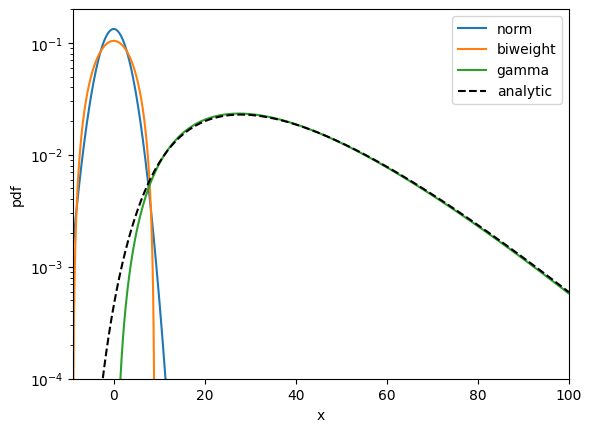

In [26]:
plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_gamma, yvals_biweight, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma(xvals, 3.75, 0.1, sigma)
#plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 100.0])
plt.ylim([1.e-4, 0.2])
plt.yscale('log')
plt.legend()
plt.show()

In [14]:
print(conv_vals2[550:])
print(xvals[550:])

[0.00039182 0.00039218 0.00039255 ... 0.00090334 0.00090333 0.00090332]
[ -3.00440044  -2.99349935  -2.98259826 ...  99.97819782  99.98909891
 100.        ]


In [15]:
print(xvals[2000])

12.802180218021803


In [16]:
a = 1.001
b = 0.001
s = 9.0
x = -5

g_a = gamma(a)
g_1pa = gamma(1+a)
g_2pa = gamma(2+a)
g_4pa = gamma(4+a)
gincc_a = gammaincc(a, b*(s+x)) * g_a
gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

print(g_a)
print(g_1pa)
print(g_2pa)
print(g_4pa)
print(gincc_a)
print(gincc_1pa)
print(gincc_2pa)
print(gincc_3pa)
print(gincc_4pa)

fbx = 4*b*x
t0 = b**4 * (s**4 - 2*s**2*x**2 + x**4)
t1 = 4*b**3 * (s**2*x - x**3)
t2 = b**2 * (6*x**2 - 2*s**2)

# branch 0 (-s < t < +s)
tsum0 = (
                (g_a - gincc_a) * t0
                + (g_1pa - gincc_1pa) * t1
                + (g_2pa - gincc_2pa) * t2
                + g_4pa - gincc_4pa
                + gincc_3pa * fbx
                - g_2pa * (2*fbx + a*fbx)
)

print(tsum0)

0.9994237724845957
1.0004231962570802
2.0018468157104174
24.03617671808178
0.9954577128485333
1.0004152654600478
2.00184679456515
6.00754229388353
24.036176718081578
4.771641415324268e-12


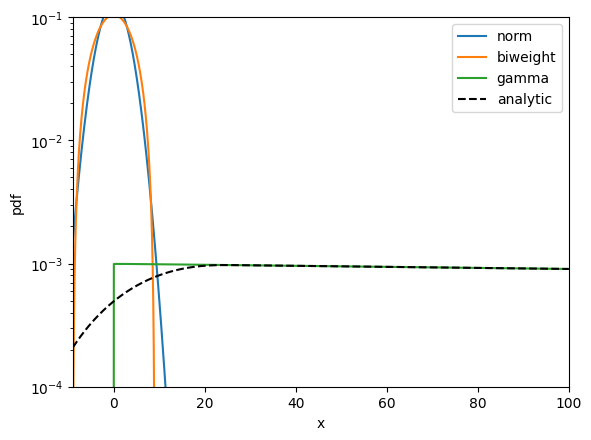

In [17]:
plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_gamma, yvals_biweight, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma(xvals, 1.001, 0.001, 3.0*sigma)
#plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 100.0])
plt.yscale('log')
plt.ylim([1.e-4, 0.1])
plt.legend()
plt.show()

In [19]:
print(conv_vals2)

[       nan        nan        nan ... 0.00076359 0.00074918 0.00076359]


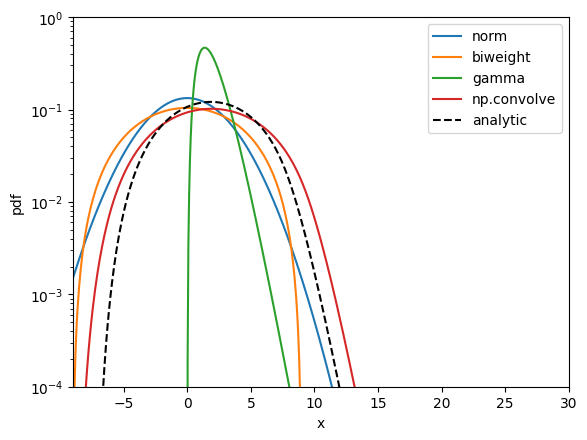

In [10]:
plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_gamma, yvals_biweight, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma(xvals, 3.75, 2.0, sigma)
plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 30.0])
plt.ylim([0.0, 0.5])
plt.yscale('log')
plt.legend()
plt.ylim([1.e-4, 1])
plt.show()

In [8]:
print(conv_vals[351])
print(xvals[348])

0.0
-9.0990990990991


In [9]:
# check normalization
quad(lambda x: biweight(x, 5.0, 9.0), -1000.0, 1000.0)

(0.9999999999935703, 1.1174318041773399e-08)

In [10]:
def biweight_gamma_wrong(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_4pa = gamma(4+a)
    g_2pa = gamma(2+a)
    
    pre_fac = 15.0/(16 * b**4 * s**5 * g_a)
    term1 = b**4 * (s**2 - x**2)**2 * g_a + 4*b**3*(s-x)*x*(s+x)*g_1pa + g_4pa

    t1 = -2*(2*(2+a)*x + b*(s**2-3*x**2))*g_2pa
    t2 = b**3 * (s**2 - x**2)**2 * gammaincc(a, b * (s+x))
    t3 = 2*b * (2*b*x*(x-s)*(s+x)*gammaincc(1+a, b*(s+x)) + (s**2-3*x**2)*gammaincc(2+a, b*(s+x)))
    t4 = 4*x* gammaincc(3+a, b*(s + x))
    term2 = b * (t1 - t2 + t3 + t4)

    term3 = gammaincc(4 + a, b*(s + x))
    #print(pre_fac * b)
    #print(t1[:3])
    #print(b * t1[:3] * pre_fac)
    return (term1 + term2 - term3) * pre_fac

In [11]:
def biweight_gamma(x, a, b, s):
    g_a = gamma(a)
    pre_fac = 15.0/(16*b**4*s**5* g_a)
    t = b**4*s**4*gamma(a) - 2*b**4*s**2*x**2*gamma(a) + b**4*x**4*gamma(a) # 1
    t += 4*b**3*s**2*x*gamma(1+a) - 4*b**3*x**3*gamma(1+a) - 2*b**2*s**2*gamma(2+a) # 2
    t += -8*b*x*gamma(2+a) - 4*a*b*x*gamma(2+a) + 6*b**2*x**2*gamma(2+a) # 3
    t += gamma(4+a) - b**4*s**4*gammaincc(a, b*(s+x))*g_a # 4
    t += 2*b**4*s**2*x**2*gammaincc(a, b*(s+x))*g_a - b**4*x**4*gammaincc(a, b*(s+x))*g_a # 5
    t += -4*b**3*s**2*x*gammaincc(1+a, b*(s+x))*gamma(1+a) + 4*b**3*x**3*gammaincc(1+a, b*(s+x))*gamma(1+a) # 6
    t += 2*b**2*s**2*gammaincc(2+a, b*(s+x))*gamma(2+a) - 6*b**2*x**2*gammaincc(2+a, b*(s+x))*gamma(2+a) # 7
    t += 4*b*x*gammaincc(3+a, b*(s+x))*gamma(3+a) - gammaincc(4+a, b*(s+x))*gamma(4+a) # 8
    return pre_fac * t  

In [222]:
def biweight_gamma2(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    gincc_a_m = gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)
    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)
    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)
    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * b**4 * (s**4 - 2*s**2*x**2 + x**4)
                + (g_1pa - gincc_1pa) * b**3 * (4*s**2*x - 4*x**3)
                + (g_2pa - gincc_2pa) * (b**2*(6*x**2 - 2*s**2))
                - g_2pa * (8*b*x + 4*a*b*x)
                + g_4pa - gincc_4pa
                + gincc_3pa * 4*b*x
    )
    
    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * (b**4*s**4 - 2*b**4*s**2*x**2 + b**4*x**4)
                + (gincc_1pa_m - gincc_1pa) * (4*b**3*s**2*x - 4*b**3*x**3)
                + (gincc_2pa- gincc_2pa_m) * (2*b**2*s**2 - 6*b**2*x**2)
                + (gincc_3pa - gincc_3pa_m) * (4*b*x)
                + gincc_4pa_m - gincc_4pa
                
    )

    tsum = np.where(x < s, tsum0, tsum1)
    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

In [210]:
def biweight_gamma3(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    b_p2 = np.power(b, 2)
    b_p3 = np.power(b, 3)
    b_p4 = np.power(b, 4)
    s_p2 = np.power(s, 2)
    s_p4 = np.power(s, 4)
    x_p2 = np.power(x, 2)
    x_p3 = np.power(x, 3)
    x_p4 = np.power(x, 4)

    pre_fac = 15.0/(16*b_p4*s**5* g_a)

    # branch 0: -s < t < s
    tsum = 0
    tsum = g_a * (b_p4*s_p4 - 2*b_p4*s_p2*x_p2 + b_p4*x_p4)
    tsum += g_1pa * (4*b_p3*s_p2*x - 4*b_p3*x_p3)
    tsum += g_2pa * (6*b_p2*x_p2 - 2*b_p2*s_p2 - 8*b*x - 4*a*b*x)
    tsum += g_4pa
    tsum += gincc_a * (-b_p4*s_p4 + 2*b_p4*s_p2*x_p2 - b_p4*x_p4)
    tsum += gincc_1pa * (4*b_p3*x_p3 - 4*b_p3*s_p2*x)
    tsum += gincc_2pa * (2*b_p2*s_p2 - 6*b_p2*x_p2)
    tsum += gincc_3pa * 4*b*x
    tsum -= gincc_4pa

    return pre_fac * tsum

In [223]:
xvals = np.linspace(-9.0, 30.0, 1000)
yvals1 = biweight_gamma(xvals, 3.75, 2.0, 9.0)
yvals2 = biweight_gamma2(xvals, 3.75, 2.0, 9.0)
yvals3 = biweight_gamma3(xvals, 3.75, 2.0, 9.0)

In [224]:
%timeit yvals1 = biweight_gamma(xvals, 3.75, 2.0, 9.0)

644 μs ± 925 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [225]:
%timeit yvals2 = biweight_gamma2(xvals, 3.75, 2.0, 9.0)

619 μs ± 1.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [226]:
%timeit yvals3 = biweight_gamma3(xvals, 3.75, 2.0, 9.0)

387 μs ± 606 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(0.0001, 1)

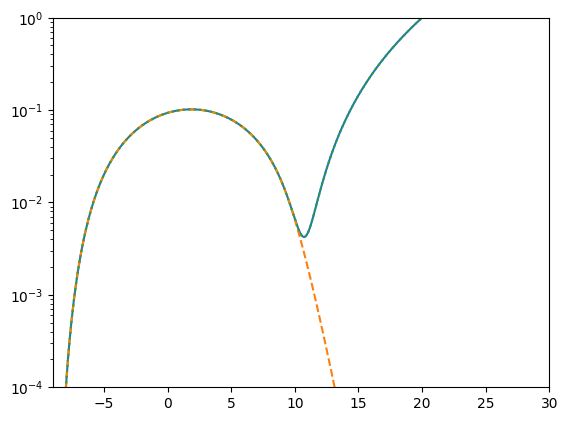

In [227]:
plt.plot(xvals, yvals1)
plt.plot(xvals, yvals2, linestyle='dashed')
plt.plot(xvals, yvals3, linestyle='dotted')
plt.xlim([-9.0, 30.0])
plt.ylim([0.0, 0.2])
plt.yscale('log')
plt.ylim([1.e-4, 1])

0.01627551838857428


(1e-07, 1)

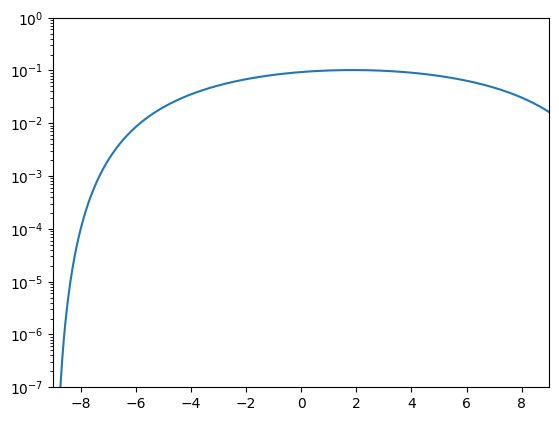

In [150]:
plt.plot(xvals, yvals)
print(yvals[-1])
plt.xlim([-9.0, 9.0])
plt.yscale('log')
plt.ylim([1.e-7, 1])

In [187]:
print(gamma(2+3.75))

78.7844810613232


In [188]:
print(xvals[np.argmax(yvals)])

1.5405405405405403


In [189]:
xvals[np.argmax(yvals)]

1.5405405405405403

In [193]:
biweight_gamma(-5.0, 3.75, 2.0, 9.0)

-0.006275703315886974

In [262]:
def biweight_gamma_term1(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = b**4*s**4*gamma(a) - 2*b**4*s**2*x**2*gamma(a) + b**4*x**4*gamma(a) # 1
    return t * pre_fac

def biweight_gamma_term2(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = 4*b**3*s**2*x*gamma(1+a) - 4*b**3*x**3*gamma(1+a) - 2*b**2*s**2*gamma(2+a) # 2
    return t * pre_fac

def biweight_gamma_term3(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = 8*b*x*gamma(2+a) - 4*a*b*x* + 6*b**2*x**2 # 3
    return t * pre_fac * gamma(2+a)

def biweight_gamma_term4(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = gamma(4+a) - b**4*s**4*gammaincc(a, b*(s+x))*gamma(a) # 4
    return t * pre_fac

def biweight_gamma_term5(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5*gamma(a))
    t = 2*b**4*s**2*x**2 - b**4*x**4 # 5
    return t * pre_fac * gammaincc(a, b*(s+x))* gamma(a)

def biweight_gamma_term6(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5*gamma(a))
    t = 4*b**3*s**2*x*gammaincc(1+a, b*(s+x))*gamma(1+a) + 4*b**3*x**3*gammaincc(1+a, b*(s+x))*gamma(1+a)
    return t * pre_fac 

In [208]:
print(biweight_gamma_term1(-5.0, 3.75, 2.0, 9.0)) # good

0.04978915815678505


In [245]:
print(biweight_gamma_term2(-5.0, 3.75, 2.0, 9.0)) # good

-0.04479446492531626


In [210]:
print(biweight_gamma_term3(-5.0, 3.75, 2.0, 9.0)) # good

0.01184236456428136


In [225]:
print(biweight_gamma_term4(-5.0, 3.75, 2.0, 9.0)) # good

-0.002743347962905882


In [243]:
print(biweight_gamma_term5(-5.0, 3.75, 2.0, 9.0)) # good

2.2434838375982898e-07
0.0017902113952547574


In [267]:
print(biweight_gamma_term6(-5.0, 3.75, 2.0, 9.0)) # good

-0.005186401877675158


In [231]:
gammaincc(3.75, 2.0*(9.0-5.0))*gamma(3.75)

0.14561322264418883

In [261]:
gammaincc(1+3.75, 2.0*(9.0-5.0))*gamma(3.75)

0.363484674896582

In [103]:
print(biweight_gamma(0.0, 3.75, 2.0, 9.0))

0.09339912661137627


In [104]:
print(biweight_gamma2(0.0, 3.75, 2.0, 9.0))

0.09339912661137627


In [79]:
from scipy.integrate import quad

In [80]:
fint = lambda x: biweight_gamma2(x, 3.75, 2.0, 9.0)

In [81]:
print(quad(fint, -8.9, 0.0))

(0.3151321442309022, 1.5141461373577897e-09)


In [110]:
%timeit biweight_gamma2(0.0, 3.75, 2.0, 9.0)

7.85 μs ± 17.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [108]:
%timeit biweight_gamma(0.0, 3.75, 2.0, 9.0)

18.4 μs ± 28.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [111]:
%timeit np.exp(-10)

713 ns ± 1.75 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [112]:
%timeit gammaincc(3.75, 0.2)

622 ns ± 2.16 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [113]:
gammaincc(3.75, 0.2)

0.999876747268292

In [44]:
print(biweight_gamma(-8.0, 3.75, 2.0, 9.0))

0.00010130538703399935


In [45]:
print(biweight_gamma2(-8.0, 3.75, 2.0, 9.0))

0.00010130538703401598


In [124]:
print(biweight_gamma2(np.array([-8.0,8.0]), 3.75, 2.0, 9.0))

[0.00010131 0.03065963]


In [125]:
print(biweight_gamma(np.array([-8.0,8.0]), 3.75, 2.0, 9.0))

[0.00010131 0.03065963]


In [126]:
print(biweight_gamma3(np.array([-8.0,8.0]), 3.75, 2.0, 9.0))

[0.00010131 0.03065963]


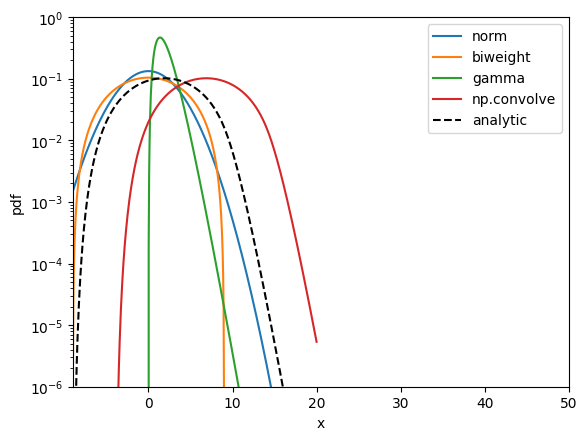

In [232]:
sigma = 3.0
mu = 0.0
xvals = np.linspace(-30, 20, 1000)

yvals_norm = norm.pdf(xvals, mu, scale=sigma)
yvals_biweight = biweight(xvals, mu, 3*sigma)
yvals_gamma = gamma_pdf_fn(xvals, 3.75, 2.0)

plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_biweight, yvals_gamma, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma2(xvals, 3.75, 2.0, 3*sigma)
plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 50.0])
plt.ylim([0.0, 0.5])
plt.yscale('log')
plt.ylim(1.e-6, 1)
plt.legend()
plt.show()